# PCA

## 課題
 　あるクラウドファンディングプロジェクトが成功するか失敗するかをプロジェクト開始前に予測する。
 
## データセット
　 Kaggle Kickstarter-projects-201801.csv

## Agenda

以下の流れで、ノートブックを作成しています。
<br>
 <br>
(1) データの前処理
 <br>
 データの中身を確認し、前処理を行う。
 <br>
 <br>
 <br>
  (2) PCAのモデル構築
 <br>
  　前処理を行ったデータに対して、PCAのモデル構築を行う。
 <br>
 <br>
 <br>
 <br>
  (3-1) モデル構築 (ニューラルネットワーク)
 <br>
  　ニューラルネットワークのモデル構築を行う。このモデルを「モデル1」とし、次元圧縮を行っていないデータ(前処理済み)を用いたときのモデルの性能評価を行う。
 <br>
 <br>
  (3-2) モデル1に対して交点探索
 <br>
  　モデル1に対して交点探索を適用し、ハイパーパラメータチューニングを行う。
 <br>
 <br>
   (3-3) モデル1に対してランダムサーチ
 <br>
  　モデル1に対してランダムサーチを適用し、ハイパーパラメータチューニングを行う。
 <br>
 <br>
    (3-4) モデル1に対してベイズ最適化
 <br>
  　モデル1に対してベイズ最適化を適用し、ハイパーパラメータチューニングを行う。
 <br>
 <br>
  (3-5) モデル1に対する交点探索、ランダムサーチ、ベイズ最適化の精度の比較
 <br>
 <br>
 <br>
 <br>
  (4-1) (2)で次元圧縮したデータに対して性能評価
      <br>
  　PCAで次元圧縮を行ったデータに対するニューラルネットワークを構築する。このモデルを「モデル2」とし、次元圧縮を行ったデータを用いたときのモデルの性能評価を行う。
 <br>
 <br>
 (4-2) モデル2に対して交点探索
 <br>
  　モデル2に対して交点探索を適用し、ハイパーパラメータチューニングを行う。
 <br>
 <br>
   (4-3) モデル2に対してランダムサーチ
 <br>
  　モデル2に対してランダムサーチを適用し、ハイパーパラメータチューニングを行う。
 <br>
 <br>
    (4-4) モデル2に対してベイズ最適化
 <br>
  　モデル2に対してベイズ最適化を適用し、ハイパーパラメータチューニングを行う。
 <br>
 <br>
  (4-5) モデル2に対する交点探索、ランダムサーチ、ベイズ最適化の精度の比較
 <br>
 <br>
 <br>
 <br>
  (5) 次元圧縮していないデータを用いたときと次元圧縮したデータを用いたときの比較
 <br>
 　モデル1とモデル2の精度を比較する。
 <br>
 <br>
 <br>
 <br>

## (1) データの前処理

データの中身を確認し、前処理を行う。

In [1]:
# ライブラリのインポート
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#データセットのインポート
df = pd.read_csv("../1_data/ks-projects-201801.csv")

### ・データの中身を確認

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


行数：378660
<br>
列数：15
<br>
「name」と「usd pledged」に欠損値あり
<br>
object(文字列)が混ざっている

### ・欠損値の確認

In [4]:
# カラムごとに含まれている欠損値の数を表示
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

### ・データ加工

#### ①プロジェクト期間に変換

「deadline」と「launched」に注目
<br>
「launched」はプロジェクトの開始日、「deadline」はプロジェクトの終了日だが、その間の日数が重要
<br>
「deadline」と「launched」をobject型からdatetime型に変更し、プロジェクト期間として扱う。

In [5]:
df['deadline'] = pd.to_datetime(df['deadline'], errors = 'coerce')
df['launched'] = pd.to_datetime(df['launched'], errors = 'coerce')

In [6]:
#日数 period
df['period'] = (df['deadline'] - df['launched']).dt.days

In [7]:
#不要になった「deadline」と「launched」の列を削除
df = df.drop(['deadline', 'launched'], axis=1)

#### ②不要である変数の削除

・「ID」「name」「currency」「country」はプロジェクトの成功に関係がないと考え、削除。
<br>
・「goal」は「usd_goal_real」があるので削除。
<br>
・「backers」「pledged」「usd pledged」「usd_pledged_real」は、プロジェクト開始前に知りえない情報なので削除。

In [8]:
df = df.drop(['ID','name','currency','country','goal','backers','pledged','usd pledged','usd_pledged_real'], axis=1)

#### ③欠損値を含む行を削除

In [9]:
# カラムごとに含まれている欠損値の数を表示
df.isnull().sum()

category         0
main_category    0
state            0
usd_goal_real    0
period           0
dtype: int64

欠損値なし。

#### ④目的変数「state」の処理

「state」の中身を確認

In [10]:
df['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

今回は、あるクラウドファンディングプロジェクトが成功するか失敗するかをプロジェクト開始前に予測するモデルを構築するので、「failed」と「successful」以外の行を削除

In [11]:
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]
df['state'].unique()

array(['failed', 'successful'], dtype=object)

「failed」を0,「successful」を1として表現する

In [12]:
df['state'] = df['state'].map({
    'failed': 0,
    'successful': 1         
})
df['state'].unique()

array([0, 1], dtype=int64)

#### ⑤データを表示

In [13]:
#見やすいようにstateを1列目に移動
first_column = df.pop('state')
df.insert(0,'state',first_column)
df.head(10)

,state,category,main_category,usd_goal_real,period
0,0,Poetry,Publishing,1533.95,58
1,0,Narrative Film,Film & Video,30000.00,59
2,0,Narrative Film,Film & Video,45000.00,44
3,0,Music,Music,5000.00,29
5,1,Restaurants,Food,50000.00,34
6,1,Food,Food,1000.00,19
7,0,Drinks,Food,25000.00,44
10,0,Nonfiction,Publishing,2406.39,29
11,1,Indie Rock,Music,12500.00,29
12,0,Crafts,Crafts,5000.00,29


#### ⑥各要素と「state」との関係を可視化

In [14]:
#train.corr()はデータの各要素（各列）同士の相関係数を表形式で視覚化する
#文字列データは自動的に外してくれる
df.corr().style.background_gradient(cmap="autumn_r")

,state,usd_goal_real,period
state,1,-0.0237352,-0.116437
usd_goal_real,-0.0237352,1,0.0216067
period,-0.116437,0.0216067,1


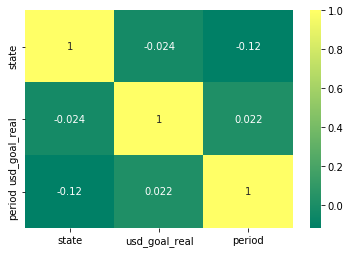

In [15]:
# seabornのheatmapを用いて量的変数の相関を可視化
sns.heatmap(df.corr(), cmap = "summer", annot = True)
plt.show()

#### ⑥「category」と「main_category」

「category」と「main_category」の中身を確認

In [16]:
df['category'].unique()

array(['Poetry', 'Narrative Film', 'Music', 'Restaurants', 'Food',
       'Drinks', 'Nonfiction', 'Indie Rock', 'Crafts', 'Games',
       'Tabletop Games', 'Design', 'Comic Books', 'Art Books', 'Fashion',
       'Childrenswear', 'Theater', 'Comics', 'DIY', 'Webseries',
       'Animation', 'Food Trucks', 'Product Design', 'Public Art',
       'Documentary', 'Illustration', 'Photography', 'Pop', 'People',
       'Art', 'Family', 'Fiction', 'Film & Video', 'Accessories', 'Rock',
       'Hardware', 'Software', 'Weaving', 'Web', 'Jazz', 'Ready-to-wear',
       'Festivals', 'Video Games', 'Anthologies', 'Publishing', 'Shorts',
       'Gadgets', 'Electronic Music', 'Radio & Podcasts', 'Cookbooks',
       'Apparel', 'Metal', 'Comedy', 'Hip-Hop', 'Periodicals', 'Dance',
       'Technology', 'Painting', 'World Music', 'Photobooks', 'Drama',
       'Architecture', 'Young Adult', 'Latin', 'Mobile Games', 'Flight',
       'Fine Art', 'Action', 'Playing Cards', 'Makerspaces', 'Punk',
       "Childre

In [17]:
df['main_category'].unique()

array(['Publishing', 'Film & Video', 'Music', 'Food', 'Crafts', 'Games',
       'Design', 'Comics', 'Fashion', 'Theater', 'Art', 'Photography',
       'Technology', 'Dance', 'Journalism'], dtype=object)

「category」は「main_category」で表現できるので削除。

In [18]:
df = df.drop(['category'], axis=1)

#### ⑥ダミー変換

「main_category」をダミー変換

In [19]:
df = pd.get_dummies(df , ['main_category'])
df.columns

Index(['state', 'usd_goal_real', 'period', 'main_category_Art',
       'main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater'],
      dtype='object')

## (2) PCAのモデル構築

前処理を行ったデータに対して、PCAのモデル構築を行う。

In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA #主成分分析用ライブラリ
from sklearn.preprocessing import StandardScaler

C:\Users\yoshi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


### ・データの中身を確認

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 18 columns):
state                         331675 non-null int64
usd_goal_real                 331675 non-null float64
period                        331675 non-null int64
main_category_Art             331675 non-null uint8
main_category_Comics          331675 non-null uint8
main_category_Crafts          331675 non-null uint8
main_category_Dance           331675 non-null uint8
main_category_Design          331675 non-null uint8
main_category_Fashion         331675 non-null uint8
main_category_Film & Video    331675 non-null uint8
main_category_Food            331675 non-null uint8
main_category_Games           331675 non-null uint8
main_category_Journalism      331675 non-null uint8
main_category_Music           331675 non-null uint8
main_category_Photography     331675 non-null uint8
main_category_Publishing      331675 non-null uint8
main_category_Technology      331675 non-null uint8
mai

目的変数：「state」
<br>
説明変数：計17個

In [22]:
df.head(10)

,state,usd_goal_real,period,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,0,1533.95,58,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,30000.00,59,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,45000.00,44,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,5000.00,29,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,1,50000.00,34,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,1,1000.00,19,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7,0,25000.00,44,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
10,0,2406.39,29,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
11,1,12500.00,29,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
12,0,5000.00,29,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


### 外れ値の確認

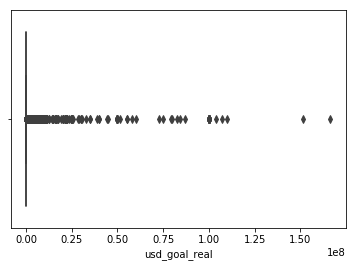

In [23]:
# 箱ひげ図による量的変数"usd_goal_real"の可視化
sns.boxplot(df["usd_goal_real"])
plt.show()

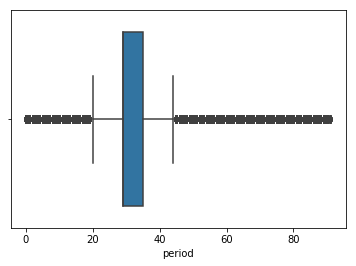

In [24]:
# 箱ひげ図による量的変数"period"の可視化
sns.boxplot(df["period"])
plt.show()

### ・データ分割

In [25]:
y = df['state'].values #'state' の値をyに代入する
X = df.drop('state', axis=1).values #'state'以外の変数をXに代入する
test_size = 0.3 #テストデータの割合を決める

#訓練データとテストデータに分割し、それぞれ変数に代入する
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

### ・説明変数の標準化

In [26]:
stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.fit_transform(X_test)

### ・主成分分析の実行

説明変数が17個あるので、17次元で寄与率を見てみる。
<br>
X_trainに対して、主成分分析を実行。

In [27]:
pca1 = PCA(n_components=17) #主成分分析用のオブジェクトをつくる。削減後の次元数を引数で指定する。
pca1.fit(X_train) #主成分分析の実行

PCA(copy=True, iterated_power='auto', n_components=17, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

### ・固有ベクトル

In [28]:
pca1.components_

array([[ 1.16262160e-01,  2.64582057e-01, -1.78390618e-01,
        -3.94537892e-02, -8.15795057e-02, -3.65699274e-02,
        -7.90193568e-02, -1.24672936e-01,  8.61137577e-01,
        -8.09180369e-02, -2.16272685e-01, -1.83706414e-02,
        -1.13916443e-01, -4.67856653e-02, -2.00020508e-01,
        -5.10347619e-03, -5.38752454e-02],
       [ 8.12045126e-04,  3.39087978e-01, -1.92643835e-01,
        -1.78951645e-02, -8.57938457e-02, -3.11256050e-02,
        -2.82682262e-02, -1.19805582e-01, -1.68573232e-01,
        -4.60604316e-02, -2.45758639e-01, -6.14269133e-03,
         8.38170726e-01, -2.73690841e-02, -1.52220749e-01,
         7.18081288e-02, -3.90462180e-02],
       [ 2.33099613e-02,  1.88487331e-01, -2.36090604e-01,
        -5.83774262e-03, -6.78566688e-02, -2.15637061e-02,
         5.33678794e-03, -1.11221429e-01, -6.74953867e-02,
        -2.45982332e-02, -3.97254266e-01,  9.96985155e-04,
        -1.55374278e-01, -1.51980767e-02,  8.16121697e-01,
         1.91477390e-01, -2.5

ノルムの大きさ、2軸の内積を計算

In [29]:
for i in range(len(pca1.components_)):
    print(np.linalg.norm(pca1.components_[i]))
for i in range(len(pca1.components_)):
    for r in range(len(pca1.components_)):
        if i==r:
            continue
        print(np.dot(pca1.components_[i], pca1.components_[r]).round(5))

0.9999999999999998
1.000000000000001
1.0000000000000009
1.0000000000000009
0.9999999999999994
0.9999999999999993
0.9999999999999998
0.9999999999999999
0.9999999999999999
0.9999999999999998
0.9999999999999999
1.0
1.0000000000000002
1.0
0.9999999999999993
1.0
0.9999999999999997
-0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
0.0
-0.0
0.0
0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
0.0
-0.0
-0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
-0.0
-0.0
0.0
-0.0
0.0
-0.0
0.0
0.0
-0.0
0.0
0.0
0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
-0.0
0.0
0.0
0.0
0.0
-0.0
0.0
0.0
0.0
-0.0
0.0
-0.0
0.0
0.0
-0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
-0.0
-0.0
-0.0
0.0
0.0
0.0
0.0
0.0
-0.0
0.0
-0.0
0.0
0.0
-0.0
0.0
-0.0
0.0
0.0
-0.0
0.0
0.0
-0.0
-0.0
-0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
0.0
-0.0
-0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
-0.0
0.0
0.0
0.0
0.0
-0.0
0.0
0.0
0.0
-0.0
-0.0
-0.0
0.0
-0.0
0.0
-0.0
-0.0
-0.0
0.0
-0.0


### ・各成分の寄与率

In [30]:
#新しい軸に投影
df2 = pd.DataFrame(pca1.transform(X))
df2.columns = ["pc1","pc2","pc3","pc4","pc5","pc6","pc7","pc8","pc9","pc10","pc11","pc12","pc13","pc14","pc15","pc16","pc17"]
df2.head(10)

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17
0,193.486079,20.760519,47.504702,310.683810,87.548065,85.559769,65.693957,66.501824,213.351078,13.911810,100.096483,-54.034583,121.338353,176.245420,1428.305726,226.938819,-0.325617
1,3504.336267,44.198971,710.352096,5888.460893,1672.111828,1722.588805,1279.136818,1221.929431,4105.095812,169.301669,1897.816453,-919.328081,2336.697752,3400.885435,27871.192232,5337.895703,-0.395585
2,5244.299930,51.293328,1057.174206,8824.738911,2506.586143,2585.942849,1918.520755,1829.682551,6154.920544,249.710343,2844.266889,-1373.328053,3503.543702,5099.446918,41804.282679,8044.000335,-0.395585
3,588.869761,14.731948,121.860565,984.638784,279.387919,286.256766,213.305030,205.032066,685.398693,30.011044,317.353004,-155.627935,390.080507,567.631319,4646.338872,873.795136,-0.363908
4,5822.022851,52.085187,1171.882036,9802.924228,2784.451665,2873.870165,2130.778284,2032.332780,6838.033446,276.042453,3159.491294,-1524.050901,3892.315288,5665.447405,46448.435266,8950.106211,-0.262169
5,121.208301,7.208656,26.866622,199.504114,56.233554,56.557347,41.877629,42.381106,138.042186,7.250192,64.205014,-32.813655,78.432384,114.100156,930.005312,163.695974,-0.262169
6,2918.114682,35.174939,591.017877,4906.413799,1393.129418,1435.644506,1065.080625,1018.326972,3420.745501,140.592701,1581.242294,-765.469280,1947.059663,2833.875724,23225.758206,4452.478284,-0.262169
7,287.244957,11.635428,62.375112,476.376860,135.086246,137.083139,102.773914,99.817792,330.861587,15.897170,153.585161,-76.849479,188.244434,273.845909,2237.079438,407.859834,-0.325617
8,1460.835958,20.822286,296.685275,2454.134659,696.890938,717.584913,533.025881,509.450596,1710.767754,70.933028,790.994025,-383.585421,973.759669,1417.229998,11613.313919,2220.574222,-0.363908
9,588.902098,13.807983,121.948082,984.872960,279.326607,286.212943,213.223982,204.970081,684.994135,29.751873,317.074074,-154.953965,390.107336,567.812160,4646.463847,873.333639,-0.159552


In [31]:
print("寄与率=",pca1.explained_variance_ratio_)
print("合計＝", pca1.explained_variance_ratio_.sum())

寄与率= [7.05416563e-02 6.89300392e-02 6.56960571e-02 6.52333080e-02
 6.40705803e-02 6.37979095e-02 6.31917465e-02 6.28138391e-02
 6.11563604e-02 6.06823642e-02 6.06168085e-02 6.05458237e-02
 5.96394070e-02 5.95291103e-02 5.83541787e-02 5.52008111e-02
 2.53861436e-30]
合計＝ 1.0


第一主成分、第二主成分だと、約14％しか説明できないことが分かる。

### ・累積寄与率

In [32]:
import numpy as np
np.cumsum(pca1.explained_variance_ratio_)

array([0.07054166, 0.1394717 , 0.20516775, 0.27040106, 0.33447164,
       0.39826955, 0.4614613 , 0.52427514, 0.5854315 , 0.64611386,
       0.70673067, 0.76727649, 0.8269159 , 0.88644501, 0.94479919,
       1.        , 1.        ])

Text(0, 0.5, 'cumulative explained variance')

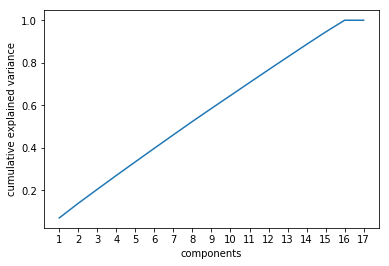

In [33]:
#図示する
import matplotlib.pyplot as plt
%matplotlib inline
 
n_components = 17
plt.plot(range(1, n_components+1), np.cumsum(pca1.explained_variance_ratio_))
plt.xticks(range(1, n_components+1))
plt.xlabel('components')
plt.xlabel('components')
plt.ylabel('cumulative explained variance')

一般的に累積寄与率が80％以上となるまでの主成分を分析に用いる。(参照 : https://www.intage.co.jp/glossary/401/)
<br>
<big>したがって、累積寄与率が約83％となる13次元まで次元を圧縮する。<big>

### ・X_train、X_testに対して次元圧縮を行い、新たなデータを作成

In [34]:
pca2 = PCA(n_components=13) #主成分分析用のオブジェクトをつくる。削減後の次元数を引数で指定する。
pca2.fit(X_train) #主成分分析の実行

PCA(copy=True, iterated_power='auto', n_components=13, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [35]:
X_train_pca = pca2.transform(X_train)
X_test_pca = pca2.transform(X_test)

## (3-1) モデル構築 (ニューラルネットワーク)

　ニューラルネットワークのモデル構築を行う。このモデルを「モデル1」とし、次元圧縮を行っていないデータ(前処理済み)を用いたときのモデルの性能評価を行う。

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras  
import tensorflow as tf

### ・次元圧縮を行っていない元々のデータを分割したものを表示

In [94]:
# one-hotベクトルに変換
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X_train=",X_train)
print()
print("X_test=",X_test)
print()
print("y_train=",y_train)
print()
print("y_test=",y_test)

X_train= [[-0.03822099 -0.31041774 -0.28853166 ... -0.34656165 -0.29774983
  -0.17746844]
 [-0.02924929 -0.31041774 -0.28853166 ... -0.34656165 -0.29774983
  -0.17746844]
 [-0.01928074  0.31944358 -0.28853166 ... -0.34656165  3.3585242
  -0.17746844]
 ...
 [-0.03223986  1.97282955 -0.28853166 ... -0.34656165 -0.29774983
  -0.17746844]
 [-0.03054447 -0.31041774 -0.28853166 ... -0.34656165 -0.29774983
  -0.17746844]
 [-0.03373514 -0.6253484  -0.28853166 ... -0.34656165 -0.29774983
  -0.17746844]]

X_test= [[-0.03481591  0.55068918 -0.2916051  ... -0.34438635 -0.298548
  -0.18089898]
 [-0.03330446 -0.7050542  -0.2916051  ... -0.34438635 -0.298548
  -0.18089898]
 [-0.03496706  2.04188445 -0.2916051  ... -0.34438635 -0.298548
  -0.18089898]
 ...
 [-0.03368232 -0.15566647 -0.2916051  ... -0.34438635 -0.298548
  -0.18089898]
 [-0.03141515 -0.31263439 -0.2916051  ... -0.34438635 -0.298548
  -0.18089898]
 [-0.03141515  2.04188445 -0.2916051  ... -0.34438635 -0.298548
  -0.18089898]]

y_train= [

### ・Tensorflowでニューラルネットワークを構築

モデル1を構築する。説明変数は17個あるので、入力層の次元は17。

In [38]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model1 = Sequential()
model1.add(Dense(20, activation='relu', input_dim=17))
model1.add(Dense(10, activation='relu', input_dim=20))
model1.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model1.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### ・次元圧縮していないデータを用いたときのモデルの性能評価

Train on 232172 samples, validate on 99503 samples
Epoch 1/50
232172/232172 [==============================] - 13s 56us/sample - loss: 0.6444 - acc: 0.6306 - val_loss: 0.6372 - val_acc: 0.6380
Epoch 2/50
232172/232172 [==============================] - 10s 41us/sample - loss: 0.6398 - acc: 0.6341 - val_loss: 0.6358 - val_acc: 0.6406
Epoch 3/50
232172/232172 [==============================] - 11s 47us/sample - loss: 0.6375 - acc: 0.6353 - val_loss: 0.6332 - val_acc: 0.6406
Epoch 4/50
232172/232172 [==============================] - 11s 49us/sample - loss: 0.6360 - acc: 0.6367 - val_loss: 0.6334 - val_acc: 0.6425
Epoch 5/50
232172/232172 [==============================] - 12s 53us/sample - loss: 0.6346 - acc: 0.6368 - val_loss: 0.6326 - val_acc: 0.6425
Epoch 6/50
232172/232172 [==============================] - 11s 49us/sample - loss: 0.6335 - acc: 0.6377 - val_loss: 0.6306 - val_acc: 0.6398
Epoch 7/50
232172/232172 [==============================] - 12s 52us/sample - loss: 0.6330 - acc:

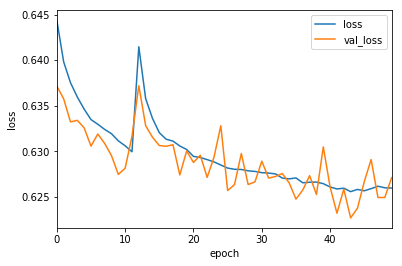

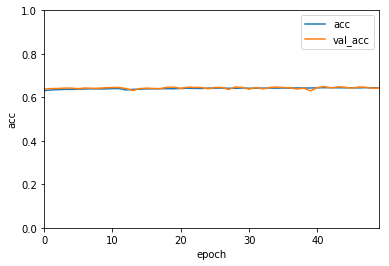

In [39]:
# 計算の実行
fit = model1.fit(X_train, y_train,
          epochs=50,
          batch_size=20,validation_data=(X_test, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

val_accuracy：64.6％

## (3-2) モデル1に対して交点探索

モデル1に対して交点探索を適用し、ハイパーパラメータチューニングを行う。

In [48]:
#モデル1を定義
def model1(activation="relu" , optimizer="sgd"):
    model = Sequential()
    model.add(Dense(20, activation=activation, input_dim=17))
    model.add(Dense(10, activation=activation, input_dim=20))
    model.add(Dense(2, activation='softmax'))
    optimizer = tf.keras.optimizers.RMSprop(0.0008)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [49]:
#交点探索対象のハイパーパラメーターを準備
activation = ["relu","sigmoid"] #sigmoid
optimizer = ["sgd","adam"] #adam
nb_epoch = [30,50] #30,50
batch_size = [5,10]  #5,10

#交点探索対象のハイパーパラメーターを辞書型にまとめる
param_grid = dict(activation=activation, optimizer=optimizer,nb_epoch=nb_epoch, batch_size=batch_size)

#モデルを作成
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn = model1, verbose=0)

#交点探索の実行
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

C:\Users\yoshi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [50]:
print (grid_result.best_params_)
print (grid_result.best_score_)

{'activation': 'relu', 'batch_size': 10, 'nb_epoch': 30, 'optimizer': 'adam'}
0.6391726836641485


## (3-3) モデル1に対してランダムサーチ

モデル1に対してランダムサーチを適用し、ハイパーパラメータチューニングを行う。

In [52]:
#ランダムサーチ用パラメーターを準備
activation = ["relu", "sigmoid"]
optimizer = ["sgd", "adam"]
nb_epoch = [30, 50]
batch_size = [5, 10]

#ランダムサーチ対象のハイパーパラメーターを辞書型にまとめる
param_dict = dict(activation=activation, 
                  optimizer=optimizer,
                  nb_epoch=nb_epoch, 
                  batch_size=batch_size)

#モデルを作成
model = KerasClassifier(build_fn = model1, verbose=0)

#ランダムサーチの実行
from sklearn.model_selection import RandomizedSearchCV
rand = RandomizedSearchCV(estimator=model, param_distributions=param_dict, n_iter=10)
rand_result = rand.fit(X_train, y_train)

C:\Users\yoshi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [53]:
print (rand_result.best_params_)
print (rand_result.best_score_)

{'optimizer': 'sgd', 'nb_epoch': 30, 'batch_size': 5, 'activation': 'relu'}
0.6370794078310745


## (3-4) モデル1に対してベイズ最適化

モデル1に対してベイズ最適化を適用し、ハイパーパラメータチューニングを行う。

In [73]:
#モデル1を再定義
def model1(lr, batch_size):  
    model = Sequential()
    model.add(Dense(20, activation="relu", input_dim=17))
    model.add(Dense(10, activation="relu", input_dim=20))
    model.add(Dense(2, activation='softmax'))
    optimizer = tf.keras.optimizers.RMSprop(lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    #訓練データでトレーニング
    model.fit(X_train, y_train,verbose=0, batch_size=int(batch_size))  
    
    #テストデータで精度を確認
    score = model.evaluate(X_test, y_test)
    return score[0]

In [69]:
#ベイズ最適化用の関数
def bayesOpt():
    pbounds = {
        'batch_size' : (5,10),
        'lr' : (0.001, 1.0)
    }
    optimizer = BayesianOptimization(f=model1, pbounds=pbounds)
    optimizer.maximize(init_points=5, n_iter=10, acq='ucb')
    return optimizer

In [70]:
#ベイズ最適化の実行
from bayes_opt import BayesianOptimization
result = bayesOpt()

|   iter    |  target   | batch_... |    lr     |
-------------------------------------------------
99503/99503 [==============================] - 6s 59us/sample - loss: 1.0662 - acc: 0.59752s - loss: 1 - ETA: 1s - loss: 1.0664 - acc: - ETA: 0s - loss: 1.06
|  1        | -1.066    |  6.888    |  0.9062   |
99503/99503 [==============================] - 6s 63us/sample - loss: 0.6937 - acc: 0.4025
|  2        | -0.6937   |  8.502    |  0.5729   |
99503/99503 [==============================] - 6s 56us/sample - loss: 0.7703 - acc: 0.4025
|  3        | -0.7703   |  9.481    |  0.6174   |
99503/99503 [==============================] - 6s 62us/sample - loss: 1.1812 - acc: 0.4025
|  4        | -1.181    |  6.699    |  0.7923   |
99503/99503 [==============================] - 7s 66us/sample - loss: 1.0428 - acc: 0.5975
|  5        | -1.043    |  6.075    |  0.7161   |
99503/99503 [==============================] - 6s 58us/sample - loss: 0.7122 - acc: 0.6184
|  6        | -0.7122   |  5.009    |

In [71]:
result.max

{'target': -0.6351838404638243, 'params': {'batch_size': 10.0, 'lr': 0.001}}

In [74]:
score=model1(0.001,10)
print(score)

99503/99503 [==============================] - 12s 117us/sample - loss: 0.6321 - acc: 0.6436
0.6321303615588949


## (3-5) モデル1に対する交点探索、ランダムサーチ、ベイズ最適化の精度の比較

モデル1に対する精度
<br>
・交点探索　　　　　63.9%
<br>
・ランダムサーチ　　63.7%
<br>
・ベイズ最適化　　　64.4%

## (4-1) (2)で次元圧縮したデータに対して性能評価

　PCAで次元圧縮を行ったデータに対するニューラルネットワークを構築する。このモデルを「model2」とし、次元圧縮を行ったデータを用いたときのモデルの性能評価を行う。

### ・次元圧縮したデータを分割したものを表示

In [37]:
# one-hotベクトルに変換
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("X_train_pca=",X_train_pca)
print()
print("X_test_pca=",X_test_pca)
print()
print("y_train=",y_train)
print()
print("y_test=",y_test)

X_train_pca= [[-0.89363024 -0.9956726  -1.47727683 ...  0.10634229 -0.22729331
  -0.05993036]
 [-0.4516469   2.30371409 -0.51134919 ... -0.06312254  0.17174838
  -0.08914204]
 [ 0.02694529  0.35588627  0.7570356  ... -0.17754709  0.27125709
  -0.23862258]
 ...
 [ 0.15673039  0.46907134  0.26953888 ...  0.10598562 -0.22738543
  -0.08861795]
 [-0.66045501 -0.68614983 -0.50962593 ... -1.96026185  4.78791011
  -0.02164599]
 [-0.50321408 -0.33334997 -0.1014067  ... -0.06872934  0.1655292
  -0.16673982]]

X_test_pca= [[-0.226659    2.60451796 -0.34930942 ... -0.0163555   0.0640107
  -0.06045353]
 [-0.52601519 -0.35936308 -0.11511112 ... -0.07366795  0.1774763
  -0.16975825]
 [ 0.16786694  3.11016422 -0.06824153 ...  0.06630746 -0.12636073
  -0.00952854]
 ...
 [ 2.20550441 -0.51453087 -0.21104417 ... -0.06010178  0.11142986
  -0.08982728]
 [-0.2891515  -0.17492961 -0.05225939 ...  0.11365228 -0.24288649
   8.7555096 ]
 [ 0.16827989  3.11016711 -0.06815874 ...  0.06653177 -0.12646868
  -0.0092

### ・Tensorflowでニューラルネットワークを構築

モデル2を構築する。13次元まで次元圧縮を行っているので、入力層の次元は13。

In [38]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model2 = Sequential()
model2.add(Dense(20, activation='relu', input_dim=13))   #13次元まで次元圧縮を行っているので、input_dimは13。
model2.add(Dense(10, activation='relu', input_dim=20))
model2.add(Dense(2, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### ・次元圧縮したデータを用いたときのモデルの性能評価

Train on 232172 samples, validate on 99503 samples
Epoch 1/50
232172/232172 [==============================] - 5s 22us/sample - loss: 0.6476 - acc: 0.6286 - val_loss: 0.6463 - val_acc: 0.6281
Epoch 2/50
232172/232172 [==============================] - 5s 21us/sample - loss: 0.6451 - acc: 0.6315 - val_loss: 0.6429 - val_acc: 0.6361
Epoch 3/50
232172/232172 [==============================] - 5s 21us/sample - loss: 0.6441 - acc: 0.6330 - val_loss: 0.6425 - val_acc: 0.6331
Epoch 4/50
232172/232172 [==============================] - 5s 21us/sample - loss: 0.6434 - acc: 0.6333 - val_loss: 0.6434 - val_acc: 0.6332
Epoch 5/50
232172/232172 [==============================] - 5s 21us/sample - loss: 0.6430 - acc: 0.6335 - val_loss: 0.6425 - val_acc: 0.6390
Epoch 6/50
232172/232172 [==============================] - 5s 21us/sample - loss: 0.6428 - acc: 0.6341 - val_loss: 0.6419 - val_acc: 0.6399
Epoch 7/50
232172/232172 [==============================] - 5s 21us/sample - loss: 0.6427 - acc: 0.6344

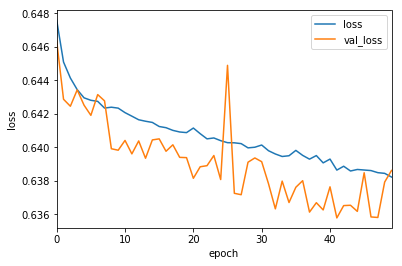

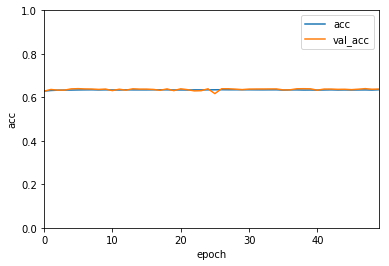

In [39]:
# 計算の実行
fit = model2.fit(X_train_pca, y_train,
          epochs=50,
          batch_size=20,validation_data=(X_test_pca, y_test))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

# グラフ化
df[["loss", "val_loss"]].plot()
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

df[["acc", "val_acc"]].plot()
plt.ylabel("acc")
plt.xlabel("epoch")
plt.ylim([0,1.0])
plt.show()

val_accuracy：63.8％

## (4-2) モデル2に対して交点探索

モデル2に対して交点探索を適用し、ハイパーパラメータチューニングを行う。

In [40]:
#モデル2を定義
def model2(activation="relu" , optimizer="sgd"):
    model = Sequential()
    model.add(Dense(20, activation=activation, input_dim=13))
    model.add(Dense(10, activation=activation, input_dim=20))
    model.add(Dense(2, activation='softmax'))
    optimizer = tf.keras.optimizers.RMSprop(0.0008)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [41]:
#交点探索対象のハイパーパラメーターを準備
activation = ["relu","sigmoid"] #sigmoid
optimizer = ["sgd","adam"] #adam
nb_epoch = [30,50] #30,50
batch_size = [5,10]  #5,10

#交点探索対象のハイパーパラメーターを辞書型にまとめる
param_grid = dict(activation=activation, optimizer=optimizer,nb_epoch=nb_epoch, batch_size=batch_size)

#モデルを作成
from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn = model2, verbose=0)

#交点探索の実行
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train_pca, y_train)

Using TensorFlow backend.
C:\Users\yoshi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [42]:
print (grid_result.best_params_)
print (grid_result.best_score_)

{'activation': 'relu', 'batch_size': 5, 'nb_epoch': 50, 'optimizer': 'sgd'}
0.6345252655078769


## (4-3) モデル2に対してランダムサーチ

モデル2に対してランダムサーチを適用し、ハイパーパラメータチューニングを行う。

In [44]:
#ランダムサーチ用パラメーターを準備
activation = ["relu", "sigmoid"]
optimizer = ["sgd", "adam"]
nb_epoch = [30, 50]
batch_size = [5, 10]

#ランダムサーチ対象のハイパーパラメーターを辞書型にまとめる
param_dict = dict(activation=activation, 
                  optimizer=optimizer,
                  nb_epoch=nb_epoch, 
                  batch_size=batch_size)

#モデルを作成
model = KerasClassifier(build_fn = model2, verbose=0)

#ランダムサーチの実行
from sklearn.model_selection import RandomizedSearchCV
rand = RandomizedSearchCV(estimator=model, param_distributions=param_dict, n_iter=10)
rand_result = rand.fit(X_train_pca, y_train)

C:\Users\yoshi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [45]:
print (rand_result.best_params_)
print (rand_result.best_score_)

{'optimizer': 'adam', 'nb_epoch': 50, 'batch_size': 5, 'activation': 'relu'}
0.6336982855114559


## (4-4) モデル2に対してベイズ最適化

モデル2に対してベイズ最適化を適用し、ハイパーパラメータチューニングを行う。

In [46]:
#モデル2を再定義
def model2(lr, batch_size):  
    model = Sequential()
    model.add(Dense(20, activation="relu", input_dim=13))
    model.add(Dense(10, activation="relu", input_dim=20))
    model.add(Dense(2, activation='softmax'))
    optimizer = tf.keras.optimizers.RMSprop(lr)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    #訓練データでトレーニング
    model.fit(X_train_pca, y_train,verbose=0, batch_size=int(batch_size))  
    
    #テストデータで精度を確認
    score = model.evaluate(X_test_pca, y_test)
    return score[0]

In [49]:
#ベイズ最適化用の関数
def bayesOpt():
    pbounds = {
        'batch_size' : (5,10),
        'lr' : (0.001, 1.0)
    }
    optimizer = BayesianOptimization(f=model2, pbounds=pbounds)
    optimizer.maximize(init_points=5, n_iter=10, acq='ucb')
    return optimizer

In [50]:
#ベイズ最適化の実行
from bayes_opt import BayesianOptimization
result = bayesOpt()

|   iter    |  target   | batch_... |    lr     |
-------------------------------------------------
99503/99503 [==============================] - 2s 19us/sample - loss: 0.7044 - acc: 0.5975
|  1        |  0.7044   |  8.073    |  0.3682   |
99503/99503 [==============================] - 2s 19us/sample - loss: 0.7269 - acc: 0.5975
|  2        |  0.7269   |  8.686    |  0.8939   |
99503/99503 [==============================] - 2s 20us/sample - loss: 0.6740 - acc: 0.5975
|  3        |  0.674    |  6.953    |  0.1044   |
99503/99503 [==============================] - 2s 20us/sample - loss: 1.5373 - acc: 0.4025
|  4        |  1.537    |  7.968    |  0.6425   |
99503/99503 [==============================] - 2s 20us/sample - loss: 0.6930 - acc: 0.5975
|  5        |  0.693    |  9.874    |  0.2739   |
99503/99503 [==============================] - 2s 21us/sample - loss: 0.7391 - acc: 0.4025
|  6        |  0.7391   |  6.313    |  0.9189   |
99503/99503 [==============================] - 2s 21us

In [51]:
result.max

{'target': 1.5373350245477484,
 'params': {'batch_size': 7.968235896623833, 'lr': 0.6425437148099099}}

In [52]:
score=model2(0.6425437148099099,7.968235896623833)
print(score)

99503/99503 [==============================] - 2s 23us/sample - loss: 0.6958 - acc: 0.5975
0.6957843003940993


## (4-5) モデル2に対する交点探索、ランダムサーチ、ベイズ最適化の精度の比較

モデル2に対する精度
<br>
・交点探索　　　　　63.5%
<br>
・ランダムサーチ　　63.3%
<br>
・ベイズ最適化　　　59.8%

## (5) 次元圧縮していないデータを用いたときと次元圧縮したデータを用いたときの比較

モデル1とモデル2の精度を比較する。

　次元圧縮していないデータを用いたときの最も高い精度は64.4%であり、次元圧縮したデータを用いたときの最も高い精度は63.5%であった。この要因を考える。
<br>
　PCAを行った際の累積寄与率のグラフを見てみると、グラフは線形になっており、第4主成分から第16主成分まで、それぞれの寄与率が約6％で、ほとんど等しくなっていた。第一主成分、第二主成分の寄与率も約7％で、ほとんど変わらない。したがって、17次元から13次元まで次元圧縮することで、大きな情報が失われてしまい、結果として次元圧縮したデータを用いた時の方が精度が低くなってしまったのではないかと考えられる。しかし、PCAで次元圧縮することで、学習速度も早まり、精度も極端に落ちることはなかった。データによっては、次元圧縮により、説明変数(特徴量)が多いことによる過学習を避けることができ、結果汎化性能が上がることも大いにあると考えられる。